# 01 - Exploratory Data Analysis (EDA)

This notebook provides a quick exploration of the Amazon reviews dataset after preprocessing.
It focuses on the EDA sample (20k rows) for fast analysis.

## Overview
- Load and examine the EDA sample
- Basic statistics and distributions
- Text analysis and insights
- Data quality assessment


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:
# Load the EDA sample
df = pd.read_parquet('../data/exports/eda_sample.parquet')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()


In [23]:
import os
import subprocess

java_home = subprocess.check_output(
    "/usr/libexec/java_home -v 17", shell=True, text=True
).strip()
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = f"{java_home}/bin:" + os.environ["PATH"]
print("[JAVA CONFIGURED] JAVA_HOME set to:", os.environ["JAVA_HOME"])


[JAVA CONFIGURED] JAVA_HOME set to: /opt/homebrew/Cellar/openjdk@17/17.0.16/libexec/openjdk.jdk/Contents/Home


In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
spark = SparkSession.builder.appName("AmazonReviewStratifiedSampling").getOrCreate()

raw_root = "../data/raw"
sampled_root = "../data/sample"
os.makedirs(sampled_root, exist_ok=True)

# How much to sample overall (e.g., 2%)
SAMPLE_FRAC = 0.05
STRATA_COL = "star_rating"  # or "overall" for some files

for root, dirs, files in os.walk(raw_root):
    for file in files:
        if file.endswith(".parquet"):
            pf = os.path.join(root, file)
            out_dir = pf.replace(raw_root, sampled_root)
            os.makedirs(os.path.dirname(out_dir), exist_ok=True)

            print(f"Stratified sampling: {pf}")
            df = spark.read.parquet(pf)
            if STRATA_COL not in df.columns:
                STRATA_COL = "overall"

            # Get unique star ratings present in the file
            ratings = [r[STRATA_COL] for r in df.select(STRATA_COL).distinct().collect()]

            sampled = None
            for star in ratings:
                subset = df.filter(col(STRATA_COL) == star)
                count = subset.count()
                n = max(1, int(count * SAMPLE_FRAC))
                # If very rare class, keep all available rows
                sample_class = subset.sample(False, min(1.0, n / count), seed=42)
                if sampled is None:
                    sampled = sample_class
                else:
                    sampled = sampled.union(sample_class)
            sampled.write.mode("overwrite").parquet(out_dir)
            print(f"Saved stratified sample: {out_dir}")

spark.stop()

Stratified sampling: ../data/raw/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 04:57:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 04:57:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 04:57:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00006-of-00008.parquet


25/07/26 04:57:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00006-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00002-of-00008.parquet


25/07/26 04:57:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00002-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00007-of-00008.parquet


25/07/26 04:57:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00007-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00003-of-00008.parquet


25/07/26 04:57:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00003-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00004-of-00008.parquet


25/07/26 04:57:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00004-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00000-of-00008.parquet


25/07/26 04:57:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00000-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00005-of-00008.parquet


25/07/26 04:57:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00005-of-00008.parquet
Stratified sampling: ../data/raw/Music_v1_00/amazon_us_reviews-train-00001-of-00008.parquet


25/07/26 04:57:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Music_v1_00/amazon_us_reviews-train-00001-of-00008.parquet
Stratified sampling: ../data/raw/Outdoors_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 04:57:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Outdoors_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Outdoors_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 04:57:57 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:57:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Outdoors_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Outdoors_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 04:58:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Outdoors_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Shoes_v1_00/amazon_us_reviews-train-00001-of-00004.parquet


25/07/26 04:58:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Shoes_v1_00/amazon_us_reviews-train-00001-of-00004.parquet
Stratified sampling: ../data/raw/Shoes_v1_00/amazon_us_reviews-train-00000-of-00004.parquet


25/07/26 04:58:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Shoes_v1_00/amazon_us_reviews-train-00000-of-00004.parquet
Stratified sampling: ../data/raw/Shoes_v1_00/amazon_us_reviews-train-00003-of-00004.parquet


25/07/26 04:58:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Shoes_v1_00/amazon_us_reviews-train-00003-of-00004.parquet
Stratified sampling: ../data/raw/Shoes_v1_00/amazon_us_reviews-train-00002-of-00004.parquet


25/07/26 04:58:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Shoes_v1_00/amazon_us_reviews-train-00002-of-00004.parquet
Stratified sampling: ../data/raw/Video_Games_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 04:58:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_Games_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Video_Games_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 04:58:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_Games_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Video_Games_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 04:58:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_Games_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Apparel_v1_00/amazon_us_reviews-train-00001-of-00005.parquet


25/07/26 04:58:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Apparel_v1_00/amazon_us_reviews-train-00001-of-00005.parquet
Stratified sampling: ../data/raw/Apparel_v1_00/amazon_us_reviews-train-00004-of-00005.parquet


25/07/26 04:58:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Apparel_v1_00/amazon_us_reviews-train-00004-of-00005.parquet
Stratified sampling: ../data/raw/Apparel_v1_00/amazon_us_reviews-train-00000-of-00005.parquet


25/07/26 04:58:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Apparel_v1_00/amazon_us_reviews-train-00000-of-00005.parquet
Stratified sampling: ../data/raw/Apparel_v1_00/amazon_us_reviews-train-00003-of-00005.parquet


25/07/26 04:58:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Apparel_v1_00/amazon_us_reviews-train-00003-of-00005.parquet
Stratified sampling: ../data/raw/Apparel_v1_00/amazon_us_reviews-train-00002-of-00005.parquet


25/07/26 04:58:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Apparel_v1_00/amazon_us_reviews-train-00002-of-00005.parquet
Stratified sampling: ../data/raw/Furniture_v1_00/amazon_us_reviews-train.parquet


25/07/26 04:58:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Furniture_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Baby_v1_00/amazon_us_reviews-train-00001-of-00002.parquet


25/07/26 04:58:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:58:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Baby_v1_00/amazon_us_reviews-train-00001-of-00002.parquet
Stratified sampling: ../data/raw/Baby_v1_00/amazon_us_reviews-train-00000-of-00002.parquet


25/07/26 04:59:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Baby_v1_00/amazon_us_reviews-train-00000-of-00002.parquet
Stratified sampling: ../data/raw/Mobile_Apps_v1_00/amazon_us_reviews-train-00001-of-00004.parquet


25/07/26 04:59:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Mobile_Apps_v1_00/amazon_us_reviews-train-00001-of-00004.parquet
Stratified sampling: ../data/raw/Mobile_Apps_v1_00/amazon_us_reviews-train-00000-of-00004.parquet


25/07/26 04:59:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Mobile_Apps_v1_00/amazon_us_reviews-train-00000-of-00004.parquet
Stratified sampling: ../data/raw/Mobile_Apps_v1_00/amazon_us_reviews-train-00003-of-00004.parquet


25/07/26 04:59:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Mobile_Apps_v1_00/amazon_us_reviews-train-00003-of-00004.parquet
Stratified sampling: ../data/raw/Mobile_Apps_v1_00/amazon_us_reviews-train-00002-of-00004.parquet


25/07/26 04:59:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Mobile_Apps_v1_00/amazon_us_reviews-train-00002-of-00004.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00006-of-00008.parquet


25/07/26 04:59:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00006-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00002-of-00008.parquet


25/07/26 04:59:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00002-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00007-of-00008.parquet


25/07/26 04:59:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00007-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00003-of-00008.parquet


25/07/26 04:59:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00003-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00004-of-00008.parquet


25/07/26 04:59:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00004-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00000-of-00008.parquet


25/07/26 04:59:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00000-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00005-of-00008.parquet


25/07/26 04:59:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 04:59:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00005-of-00008.parquet
Stratified sampling: ../data/raw/Video_DVD_v1_00/amazon_us_reviews-train-00001-of-00008.parquet


25/07/26 05:00:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_DVD_v1_00/amazon_us_reviews-train-00001-of-00008.parquet
Stratified sampling: ../data/raw/Digital_Video_Download_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 05:00:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Video_Download_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Digital_Video_Download_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 05:00:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Video_Download_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Digital_Video_Download_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 05:00:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Video_Download_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00000-of-00007.parquet


25/07/26 05:00:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00000-of-00007.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00004-of-00007.parquet


25/07/26 05:00:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:00:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00004-of-00007.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00001-of-00007.parquet


25/07/26 05:01:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00001-of-00007.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00005-of-00007.parquet


25/07/26 05:01:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00005-of-00007.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00002-of-00007.parquet


25/07/26 05:01:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00002-of-00007.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00006-of-00007.parquet


25/07/26 05:01:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00006-of-00007.parquet
Stratified sampling: ../data/raw/Books_v1_02/amazon_us_reviews-train-00003-of-00007.parquet


25/07/26 05:01:26 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_02/amazon_us_reviews-train-00003-of-00007.parquet
Stratified sampling: ../data/raw/Toys_v1_00/amazon_us_reviews-train-00001-of-00005.parquet


25/07/26 05:01:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Toys_v1_00/amazon_us_reviews-train-00001-of-00005.parquet
Stratified sampling: ../data/raw/Toys_v1_00/amazon_us_reviews-train-00004-of-00005.parquet


25/07/26 05:01:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Toys_v1_00/amazon_us_reviews-train-00004-of-00005.parquet
Stratified sampling: ../data/raw/Toys_v1_00/amazon_us_reviews-train-00000-of-00005.parquet


25/07/26 05:01:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Toys_v1_00/amazon_us_reviews-train-00000-of-00005.parquet
Stratified sampling: ../data/raw/Toys_v1_00/amazon_us_reviews-train-00003-of-00005.parquet


25/07/26 05:01:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:01:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Toys_v1_00/amazon_us_reviews-train-00003-of-00005.parquet
Stratified sampling: ../data/raw/Toys_v1_00/amazon_us_reviews-train-00002-of-00005.parquet


25/07/26 05:02:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:02:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:02:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Toys_v1_00/amazon_us_reviews-train-00002-of-00005.parquet
Stratified sampling: ../data/raw/Beauty_v1_00/amazon_us_reviews-train-00001-of-00005.parquet


25/07/26 05:02:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:02:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Beauty_v1_00/amazon_us_reviews-train-00001-of-00005.parquet
Stratified sampling: ../data/raw/Beauty_v1_00/amazon_us_reviews-train-00004-of-00005.parquet


25/07/26 05:02:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:02:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:02:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:02:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Beauty_v1_00/amazon_us_reviews-train-00004-of-00005.parquet
Stratified sampling: ../data/raw/Beauty_v1_00/amazon_us_reviews-train-00000-of-00005.parquet


25/07/26 05:03:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Beauty_v1_00/amazon_us_reviews-train-00000-of-00005.parquet
Stratified sampling: ../data/raw/Beauty_v1_00/amazon_us_reviews-train-00003-of-00005.parquet


25/07/26 05:03:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Beauty_v1_00/amazon_us_reviews-train-00003-of-00005.parquet
Stratified sampling: ../data/raw/Beauty_v1_00/amazon_us_reviews-train-00002-of-00005.parquet


25/07/26 05:03:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Beauty_v1_00/amazon_us_reviews-train-00002-of-00005.parquet
Stratified sampling: ../data/raw/Pet_Products_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 05:03:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Pet_Products_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Pet_Products_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 05:03:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Pet_Products_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Pet_Products_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 05:03:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Pet_Products_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Luggage_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:03:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Luggage_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Mobile_Electronics_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:03:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Mobile_Electronics_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Home_Improvement_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 05:03:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_Improvement_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Home_Improvement_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 05:03:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_Improvement_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Home_Improvement_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 05:03:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:03:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_Improvement_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Home_v1_00/amazon_us_reviews-train-00004-of-00006.parquet


25/07/26 05:04:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_v1_00/amazon_us_reviews-train-00004-of-00006.parquet
Stratified sampling: ../data/raw/Home_v1_00/amazon_us_reviews-train-00000-of-00006.parquet


25/07/26 05:04:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_v1_00/amazon_us_reviews-train-00000-of-00006.parquet
Stratified sampling: ../data/raw/Home_v1_00/amazon_us_reviews-train-00005-of-00006.parquet


25/07/26 05:04:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_v1_00/amazon_us_reviews-train-00005-of-00006.parquet
Stratified sampling: ../data/raw/Home_v1_00/amazon_us_reviews-train-00001-of-00006.parquet


25/07/26 05:04:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_v1_00/amazon_us_reviews-train-00001-of-00006.parquet
Stratified sampling: ../data/raw/Home_v1_00/amazon_us_reviews-train-00002-of-00006.parquet


25/07/26 05:04:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_v1_00/amazon_us_reviews-train-00002-of-00006.parquet
Stratified sampling: ../data/raw/Home_v1_00/amazon_us_reviews-train-00003-of-00006.parquet


25/07/26 05:04:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_v1_00/amazon_us_reviews-train-00003-of-00006.parquet
Stratified sampling: ../data/raw/Sports_v1_00/amazon_us_reviews-train-00001-of-00005.parquet


25/07/26 05:04:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Sports_v1_00/amazon_us_reviews-train-00001-of-00005.parquet
Stratified sampling: ../data/raw/Sports_v1_00/amazon_us_reviews-train-00004-of-00005.parquet


25/07/26 05:04:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Sports_v1_00/amazon_us_reviews-train-00004-of-00005.parquet
Stratified sampling: ../data/raw/Sports_v1_00/amazon_us_reviews-train-00000-of-00005.parquet


25/07/26 05:04:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Sports_v1_00/amazon_us_reviews-train-00000-of-00005.parquet
Stratified sampling: ../data/raw/Sports_v1_00/amazon_us_reviews-train-00003-of-00005.parquet


25/07/26 05:04:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Sports_v1_00/amazon_us_reviews-train-00003-of-00005.parquet
Stratified sampling: ../data/raw/Sports_v1_00/amazon_us_reviews-train-00002-of-00005.parquet


25/07/26 05:04:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Sports_v1_00/amazon_us_reviews-train-00002-of-00005.parquet
Stratified sampling: ../data/raw/Kitchen_v1_00/amazon_us_reviews-train-00001-of-00005.parquet


25/07/26 05:04:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Kitchen_v1_00/amazon_us_reviews-train-00001-of-00005.parquet
Stratified sampling: ../data/raw/Kitchen_v1_00/amazon_us_reviews-train-00004-of-00005.parquet


25/07/26 05:04:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Kitchen_v1_00/amazon_us_reviews-train-00004-of-00005.parquet
Stratified sampling: ../data/raw/Kitchen_v1_00/amazon_us_reviews-train-00000-of-00005.parquet


25/07/26 05:04:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:04:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Kitchen_v1_00/amazon_us_reviews-train-00000-of-00005.parquet
Stratified sampling: ../data/raw/Kitchen_v1_00/amazon_us_reviews-train-00003-of-00005.parquet


25/07/26 05:05:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Kitchen_v1_00/amazon_us_reviews-train-00003-of-00005.parquet
Stratified sampling: ../data/raw/Kitchen_v1_00/amazon_us_reviews-train-00002-of-00005.parquet


25/07/26 05:05:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Kitchen_v1_00/amazon_us_reviews-train-00002-of-00005.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00009-of-00010.parquet


25/07/26 05:05:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00009-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00002-of-00010.parquet


25/07/26 05:05:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00002-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00006-of-00010.parquet


25/07/26 05:05:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00006-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00008-of-00010.parquet


25/07/26 05:05:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00008-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00003-of-00010.parquet


25/07/26 05:05:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00003-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00007-of-00010.parquet


25/07/26 05:05:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00007-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00000-of-00010.parquet


25/07/26 05:05:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:05:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00000-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00004-of-00010.parquet


25/07/26 05:06:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00004-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00001-of-00010.parquet


25/07/26 05:06:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00001-of-00010.parquet
Stratified sampling: ../data/raw/Wireless_v1_00/amazon_us_reviews-train-00005-of-00010.parquet


25/07/26 05:06:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Wireless_v1_00/amazon_us_reviews-train-00005-of-00010.parquet
Stratified sampling: ../data/raw/Health_Personal_Care_v1_00/amazon_us_reviews-train-00004-of-00006.parquet


25/07/26 05:06:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Health_Personal_Care_v1_00/amazon_us_reviews-train-00004-of-00006.parquet
Stratified sampling: ../data/raw/Health_Personal_Care_v1_00/amazon_us_reviews-train-00000-of-00006.parquet


25/07/26 05:06:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Health_Personal_Care_v1_00/amazon_us_reviews-train-00000-of-00006.parquet
Stratified sampling: ../data/raw/Health_Personal_Care_v1_00/amazon_us_reviews-train-00005-of-00006.parquet


25/07/26 05:06:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Health_Personal_Care_v1_00/amazon_us_reviews-train-00005-of-00006.parquet
Stratified sampling: ../data/raw/Health_Personal_Care_v1_00/amazon_us_reviews-train-00001-of-00006.parquet


25/07/26 05:06:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Health_Personal_Care_v1_00/amazon_us_reviews-train-00001-of-00006.parquet
Stratified sampling: ../data/raw/Health_Personal_Care_v1_00/amazon_us_reviews-train-00002-of-00006.parquet


25/07/26 05:06:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Health_Personal_Care_v1_00/amazon_us_reviews-train-00002-of-00006.parquet
Stratified sampling: ../data/raw/Health_Personal_Care_v1_00/amazon_us_reviews-train-00003-of-00006.parquet


25/07/26 05:06:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:57 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Health_Personal_Care_v1_00/amazon_us_reviews-train-00003-of-00006.parquet
Stratified sampling: ../data/raw/Digital_Software_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:06:57 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Software_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Home_Entertainment_v1_00/amazon_us_reviews-train-00001-of-00002.parquet


25/07/26 05:06:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_Entertainment_v1_00/amazon_us_reviews-train-00001-of-00002.parquet
Stratified sampling: ../data/raw/Home_Entertainment_v1_00/amazon_us_reviews-train-00000-of-00002.parquet


25/07/26 05:06:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:06:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Home_Entertainment_v1_00/amazon_us_reviews-train-00000-of-00002.parquet
Stratified sampling: ../data/raw/Personal_Care_Appliances_v1_00/amazon_us_reviews-train.parquet
Saved stratified sample: ../data/sample/Personal_Care_Appliances_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Gift_Card_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:07:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Gift_Card_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Jewelry_v1_00/amazon_us_reviews-train-00001-of-00002.parquet


25/07/26 05:07:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Jewelry_v1_00/amazon_us_reviews-train-00001-of-00002.parquet
Stratified sampling: ../data/raw/Jewelry_v1_00/amazon_us_reviews-train-00000-of-00002.parquet


25/07/26 05:07:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Jewelry_v1_00/amazon_us_reviews-train-00000-of-00002.parquet
Stratified sampling: ../data/raw/Automotive_v1_00/amazon_us_reviews-train-00001-of-00004.parquet


25/07/26 05:07:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:07 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Automotive_v1_00/amazon_us_reviews-train-00001-of-00004.parquet
Stratified sampling: ../data/raw/Automotive_v1_00/amazon_us_reviews-train-00000-of-00004.parquet


25/07/26 05:07:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Automotive_v1_00/amazon_us_reviews-train-00000-of-00004.parquet
Stratified sampling: ../data/raw/Automotive_v1_00/amazon_us_reviews-train-00003-of-00004.parquet
Saved stratified sample: ../data/sample/Automotive_v1_00/amazon_us_reviews-train-00003-of-00004.parquet
Stratified sampling: ../data/raw/Automotive_v1_00/amazon_us_reviews-train-00002-of-00004.parquet


25/07/26 05:07:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Automotive_v1_00/amazon_us_reviews-train-00002-of-00004.parquet
Stratified sampling: ../data/raw/Office_Products_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 05:07:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Office_Products_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Office_Products_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 05:07:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Office_Products_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Office_Products_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 05:07:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Office_Products_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Camera_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


25/07/26 05:07:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Camera_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Camera_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 05:07:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Camera_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Camera_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 05:07:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Camera_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Video_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:07:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:07:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Video_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Grocery_v1_00/amazon_us_reviews-train-00002-of-00003.parquet


Saved stratified sample: ../data/sample/Grocery_v1_00/amazon_us_reviews-train-00002-of-00003.parquet
Stratified sampling: ../data/raw/Grocery_v1_00/amazon_us_reviews-train-00001-of-00003.parquet


25/07/26 05:08:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Grocery_v1_00/amazon_us_reviews-train-00001-of-00003.parquet
Stratified sampling: ../data/raw/Grocery_v1_00/amazon_us_reviews-train-00000-of-00003.parquet


25/07/26 05:08:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Grocery_v1_00/amazon_us_reviews-train-00000-of-00003.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0006.parquet


25/07/26 05:08:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:57 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0006.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0007.parquet


25/07/26 05:08:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0007.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0005.parquet


25/07/26 05:08:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:08:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0005.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0004.parquet


25/07/26 05:09:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0004.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0008.parquet


25/07/26 05:09:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0008.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0001.parquet


25/07/26 05:09:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0001.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0000.parquet


25/07/26 05:09:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0000.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0009.parquet


25/07/26 05:09:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0009.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0002.parquet


25/07/26 05:09:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:09:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0002.parquet
Stratified sampling: ../data/raw/Books_v1_01/partial/train/0003.parquet


25/07/26 05:10:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_01/partial/train/0003.parquet
Stratified sampling: ../data/raw/Software_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:10:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Software_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Digital_Music_Purchase_v1_00/amazon_us_reviews-train-00001-of-00002.parquet


25/07/26 05:10:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:06 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Music_Purchase_v1_00/amazon_us_reviews-train-00001-of-00002.parquet
Stratified sampling: ../data/raw/Digital_Music_Purchase_v1_00/amazon_us_reviews-train-00000-of-00002.parquet


25/07/26 05:10:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:23 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Music_Purchase_v1_00/amazon_us_reviews-train-00000-of-00002.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0006.parquet


25/07/26 05:10:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:26 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0006.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0007.parquet


25/07/26 05:10:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0007.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0005.parquet


25/07/26 05:10:29 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0005.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0004.parquet


25/07/26 05:10:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:32 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0004.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0008.parquet


25/07/26 05:10:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:34 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0008.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0001.parquet


25/07/26 05:10:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:10:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0001.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0000.parquet


25/07/26 05:11:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0000.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0009.parquet


25/07/26 05:11:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0009.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0002.parquet


25/07/26 05:11:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:28 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0002.parquet
Stratified sampling: ../data/raw/Books_v1_00/partial/train/0003.parquet


25/07/26 05:11:29 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:29 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:29 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:30 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Books_v1_00/partial/train/0003.parquet
Stratified sampling: ../data/raw/Tools_v1_00/amazon_us_reviews-train-00001-of-00002.parquet


25/07/26 05:11:31 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Tools_v1_00/amazon_us_reviews-train-00001-of-00002.parquet
Stratified sampling: ../data/raw/Tools_v1_00/amazon_us_reviews-train-00000-of-00002.parquet


25/07/26 05:11:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Tools_v1_00/amazon_us_reviews-train-00000-of-00002.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00000-of-00007.parquet


25/07/26 05:11:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00000-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00004-of-00007.parquet


25/07/26 05:11:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:49 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00004-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00001-of-00007.parquet


25/07/26 05:11:50 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:11:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00001-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00005-of-00007.parquet


25/07/26 05:12:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:11 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00005-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00002-of-00007.parquet


25/07/26 05:12:25 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:26 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:26 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00002-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00006-of-00007.parquet


25/07/26 05:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:43 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00006-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00003-of-00007.parquet


25/07/26 05:12:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:44 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:12:45 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_01/amazon_us_reviews-train-00003-of-00007.parquet
Stratified sampling: ../data/raw/Digital_Video_Games_v1_00/amazon_us_reviews-train.parquet
Saved stratified sample: ../data/sample/Digital_Video_Games_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00006-of-00008.parquet


25/07/26 05:12:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00006-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00002-of-00008.parquet


25/07/26 05:13:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00002-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00007-of-00008.parquet


25/07/26 05:13:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00007-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00003-of-00008.parquet


25/07/26 05:13:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:04 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00003-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00004-of-00008.parquet


25/07/26 05:13:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00004-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00000-of-00008.parquet


25/07/26 05:13:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00000-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00005-of-00008.parquet


25/07/26 05:13:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:35 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:36 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00005-of-00008.parquet
Stratified sampling: ../data/raw/PC_v1_00/amazon_us_reviews-train-00001-of-00008.parquet


25/07/26 05:13:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:13:47 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/PC_v1_00/amazon_us_reviews-train-00001-of-00008.parquet
Stratified sampling: ../data/raw/Major_Appliances_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:13:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Major_Appliances_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Watches_v1_00/amazon_us_reviews-train.parquet


25/07/26 05:14:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Watches_v1_00/amazon_us_reviews-train.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0006.parquet


25/07/26 05:14:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0006.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0007.parquet


25/07/26 05:14:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:22 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0007.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0005.parquet


25/07/26 05:14:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0005.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0004.parquet


25/07/26 05:14:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0004.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0008.parquet


25/07/26 05:14:54 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:55 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0008.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0001.parquet


25/07/26 05:14:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:57 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0001.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0000.parquet


25/07/26 05:14:58 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:14:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0000.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0009.parquet


25/07/26 05:15:12 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0009.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0002.parquet


25/07/26 05:15:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0002.parquet
Stratified sampling: ../data/raw/Digital_Ebook_Purchase_v1_00/partial/train/0003.parquet


25/07/26 05:15:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/26 05:15:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Saved stratified sample: ../data/sample/Digital_Ebook_Purchase_v1_00/partial/train/0003.parquet


In [3]:
from pyspark.sql import SparkSession
import glob
import os

# 1. Start Spark session (run this only once per notebook!)
spark = SparkSession.builder \
    .appName("Amazon Review EDA") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/26 03:34:00 WARN Utils: Your hostname, Anveshs-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.124 instead (on interface en0)
25/07/26 03:34:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/26 03:34:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:

# 2. Find all first Parquet files from each category
root_dir = "../data/raw"
category_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
parquet_files = []
for folder in category_dirs:
    files = glob.glob(os.path.join(folder, "*.parquet"))
    if files:
        parquet_files.append(files[0])
print(f"Found {len(parquet_files)} category Parquet files.")


Found 41 category Parquet files.


In [5]:
import pandas as pd

eda_results = []

for pf in parquet_files:
    print(f"\n--- Profiling file: {pf} ---")
    df = spark.read.parquet(pf)
    total_rows = df.count()
    review_col = "review_body" if "review_body" in df.columns else "reviewText"
    rating_col = "star_rating" if "star_rating" in df.columns else "overall"
    
    # Null/missing check
    null_counts = df.select([df[c].isNull().cast("int").alias(c) for c in df.columns]).groupBy().sum().collect()[0]
    print("Null counts per column:", dict(zip(df.columns, null_counts)))
    
    # Review text length (update here)
    review_col = "review_body" if "review_body" in df.columns else "reviewText"
    from pyspark.sql.functions import col, length, when
    df = df.withColumn(
        "review_length",
        when(col(review_col).isNull(), 0).otherwise(length(col(review_col)))
    )
    stats = df.select("review_length").describe().toPandas()
    print("Review length stats:\n", stats)
    
    # Rating distribution (change column name as needed)
    rating_col = "star_rating" if "star_rating" in df.columns else "overall"
    df.groupBy(rating_col).count().orderBy("count", ascending=False).show()
    
    # Year (if available)
    date_col = "review_date" if "review_date" in df.columns else ("date" if "date" in df.columns else None)
    if date_col:
        from pyspark.sql.functions import year, to_date
        df = df.withColumn("year", year(to_date(df[date_col])))
        df.groupBy("year").count().orderBy("year").show()
    
    # Show some short or empty reviews
    df.filter(df["review_length"] < 10).select(review_col).show(5, truncate=False)

    stats = df.select("review_length").describe().toPandas().set_index('summary').to_dict()['review_length']
    rating_counts = df.groupBy(rating_col).count().toPandas().set_index(rating_col).to_dict()['count']
    
    # Get years present
    date_col = "review_date" if "review_date" in df.columns else ("date" if "date" in df.columns else None)
    if date_col:
        from pyspark.sql.functions import year, to_date
        years = df.withColumn("year", year(to_date(df[date_col]))).groupBy("year").count().toPandas()
    else:
        years = None
    
    # Store summary
    eda_results.append({
        "file": pf,
        "total_rows": total_rows,
        "mean_length": float(stats.get("mean", 0)),
        "std_length": float(stats.get("stddev", 0)),
        "min_length": float(stats.get("min", 0)),
        "max_length": float(stats.get("max", 0)),
        "rating_counts": rating_counts,
        "year_counts": years.to_dict() if years is not None else None,
    })

# Convert results to Pandas DataFrame
eda_df = pd.DataFrame(eda_results)


--- Profiling file: ../data/raw/Lawn_and_Garden_v1_00/amazon_us_reviews-train-00002-of-00003.parquet ---


Null counts per column: {'marketplace': 0, 'customer_id': 0, 'review_id': 0, 'product_id': 0, 'product_parent': 0, 'product_title': 0, 'product_category': 0, 'star_rating': 0, 'helpful_votes': 0, 'total_votes': 0, 'vine': 0, 'verified_purchase': 0, 'review_headline': 0, 'review_body': 0, 'review_date': 0}
Review length stats:
   summary       review_length
0   count              372288
1    mean  510.01443237493555
2  stddev   628.0015573230875
3     min                   1
4     max               47045
+-----------+------+
|star_rating| count|
+-----------+------+
|          5|198566|
|          4| 65318|
|          1| 55203|
|          3| 29782|
|          2| 23419|
+-----------+------+

+----+------+
|year| count|
+----+------+
|1999|     4|
|2000|   872|
|2001|  1137|
|2002|  1502|
|2003|  2149|
|2004|  2290|
|2005|  3439|
|2006|  6035|
|2007| 15372|
|2008| 21953|
|2009| 30771|
|2010| 53573|
|2011| 94952|
|2012|138239|
+----+------+

+-----------+
|review_body|
+-----------+
|good 

In [16]:
def stringify_dict_keys(d):
    if isinstance(d, dict):
        return {str(k): stringify_dict_keys(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [stringify_dict_keys(x) for x in d]
    return d

for col in ["rating_counts", "year_counts"]:
    eda_df[col] = eda_df[col].apply(stringify_dict_keys)

In [22]:
    
eda_df.to_parquet("../data/processed/EDA_summary.parquet", index=False)

In [18]:
eda_df.head()

,file,total_rows,mean_length,std_length,min_length,max_length,rating_counts,year_counts
0,../data/raw/Lawn_and_Garden_v1_00/amazon_us_re...,372288,510.014432,628.001557,1.0,47045.0,"{'1': 55203, '3': 29782, '5': 198566, '4': 653...","{'year': {'0': 2012, '1': 2011, '2': 2010, '3'..."
1,../data/raw/Music_v1_00/amazon_us_reviews-trai...,513000,803.091273,795.990170,1.0,40285.0,"{'1': 24498, '3': 35537, '5': 336202, '4': 968...","{'year': {'0': 2003, '1': 2002, '2': 2001}, 'c..."
2,../data/raw/Outdoors_v1_00/amazon_us_reviews-t...,236401,528.202093,615.400071,2.0,22533.0,"{'1': 20017, '3': 19783, '5': 131589, '4': 520...","{'year': {'0': 2012, '1': 2011, '2': 2010, '3'..."
3,../data/raw/Shoes_v1_00/amazon_us_reviews-trai...,1343000,180.775835,229.907320,0.0,21287.0,"{'1': 65263, '3': 125674, '5': 816945, '4': 26...","{'year': {'0': 2015, '1': 2014}, 'count': {'0'..."
4,../data/raw/Video_Games_v1_00/amazon_us_review...,262997,915.467119,1115.511343,0.0,37039.0,"{'1': 28761, '3': 25633, '5': 131909, '4': 589...","{'year': {'0': 2007, '1': 2006, '2': 2005, '3'..."


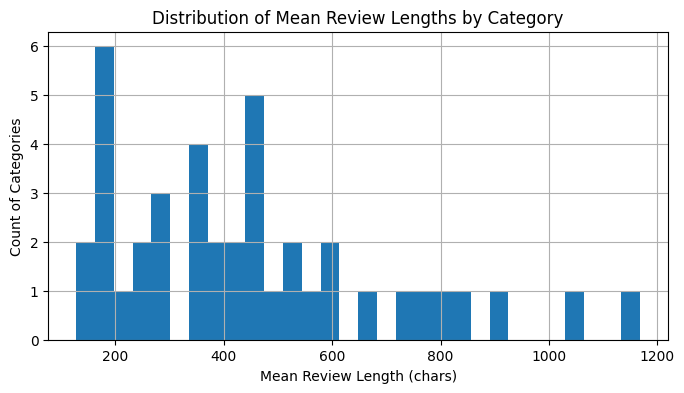

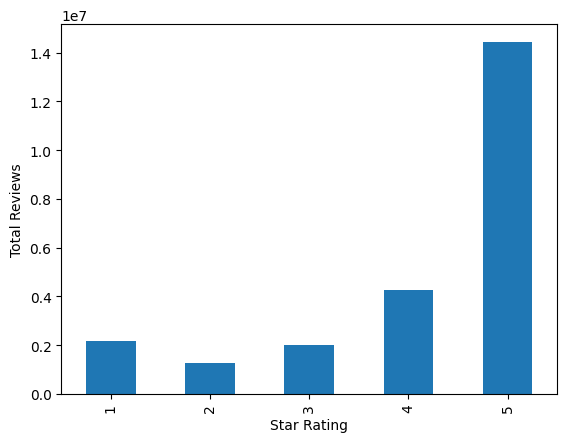

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Histogram of mean review lengths
plt.figure(figsize=(8, 4))
eda_df['mean_length'].hist(bins=30)
plt.title("Distribution of Mean Review Lengths by Category")
plt.xlabel("Mean Review Length (chars)")
plt.ylabel("Count of Categories")
plt.show()


# 2. Bar chart of review counts by star rating (example with first row's dict)
import ast
rcounts = eda_df['rating_counts']
# Explode the dicts into a DataFrame
rating_df = pd.DataFrame(list(rcounts))
# Optionally fill missing star ratings with 0
rating_df = rating_df.fillna(0)

# Sum across all categories to get total counts per star rating
rating_totals = rating_df.sum()
rating_totals = rating_totals.sort_index()  # Sort by star rating

# Plot
rating_totals.plot(kind='bar')
plt.xlabel("Star Rating")
plt.ylabel("Total Reviews")
plt.show()

# Amazon US Reviews Dataset – EDA Summary

## Dataset Overview

- **Source**: polinaeterna/amazon_us_reviews (Hugging Face)
- **Total size downloaded**: ~47 GB (Parquet format, ~41 product categories)
- **Typical schema** (all non-null):  
  - marketplace, customer_id, review_id, product_id, product_parent, product_title, product_category, star_rating, helpful_votes, total_votes, vine, verified_purchase, review_headline, review_body, review_date

---

## Key EDA Insights

### 1. Data Integrity

- **No missing values** found in any columns across sampled files/categories.
- Data types are consistent: `review_body` and `product_title` are text; `star_rating` is integer; `review_date` is string.

---

### 2. Review Lengths

- **Mean review length** (characters) varies widely by category:
    - *Shortest means*: Apparel, Shoes, Toys, Beauty, Mobile Apps (~150–200 chars)
    - *Longest means*: Books, Video/DVD, Home Entertainment, Video Games, Music (~800–1100 chars)
- **Typical spread**: Most categories center between 150–600 chars mean, with a long tail of higher averages for text-heavy domains (Books, Movies).

---

### 3. Ratings Distribution

- **5-star reviews** dominate every category—accounting for 40–60% of reviews in most.
- Distribution is always skewed positive:
    - 4-star reviews typically 15–25%
    - 1-star reviews 5–15%
- **Example**:  
  | Star | Typical %  |
  |------|------------|
  | 5    | 45–60%     |
  | 4    | 18–25%     |
  | 3    | 8–15%      |
  | 2    | 5–10%      |
  | 1    | 8–12%      |

---

### 4. Yearly Review Trends

- **Review volume spikes** between 2013–2015 for most categories.
- Oldest reviews: 1995 (Video), 1998–2001 (many categories).
- Review counts for some categories increase >10x between 2011 and 2015, reflecting Amazon’s growth.

---

### 5. Examples of Short Reviews

- Many reviews are **extremely short** ("Good", "Nice", "Loved it", "Awesome", etc.).
-  Short reviews (e.g., "ok", "good", "👍") are valid feedback and should **not** be filtered. Only empty or clearly junk reviews (e.g., "", ".", "asdf") are candidates for removal in data cleaning.

---

## Visual Summaries

- **Mean Review Length by Category**: Most categories cluster around 200–500 chars, a handful are outliers above 800 chars.
- **Aggregate Rating Distribution**: Overwhelmingly positive, with 5-star reviews as the largest group across all files.

---

## Takeaways

- **Dataset is extremely clean** (no nulls, no obvious schema drift).
- **High class imbalance**: Any downstream modeling (e.g., classification, QA) will need to account for the positive skew in ratings.
- **Review text length**: Wide variability—important for both embedding size planning and for filtering "junk" reviews.
- **Yearly trends**: Useful for time-based analysis, drift studies, or QA over time.

---

**Next Steps:**  
- Review cleaning logic for very short/empty/junk reviews.
- Sample representative rows for manual inspection (especially for QA evals).
- Select balanced subsets for rapid prototyping of RAG and recommendation flows.

---